# Reducción de dimensiones

En este notebook se ven algunos métodos de reducción de dimensiones.
El notebook sigue el ejemplo del capítulo 8 del libro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" que usa la base MNIST de dígitos manuscritos.




## Preámbulo

In [1]:
# En esta celda se definen los modulos que se van a usar en el notebook 

import numpy as np  # paquete matemático para el manejo de arreglos/arrays
import pandas as pd # paquete de manejo de datos en dataframes o series
import matplotlib.pyplot as plt # paquete para realizar gráficos

# Formato general para las figuras 
plt.rc('figure', figsize=(4,4))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
#%matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
#    Si se usa vscode usar también %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------

### Funciones auxiliares

In [2]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def plot_100_digits():
    plt.figure(figsize=(9, 9))
    for idx, image_data in enumerate(X[:100]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)
    plt.subplots_adjust(wspace=0, hspace=0)

## Base MNIST

### Cargar los datos  
[sklearn.datasets.fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html#sklearn.datasets.fetch_openml)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Contenido

In [4]:
print('Data:  (X)', mnist.data.shape)
print('Target (y):', mnist.target.shape)

print('clases:', mnist.categories)

X, y = mnist.data, mnist.target

X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

Data:  (X) (70000, 784)
Target (y): (70000,)
clases: {'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}


### Descripción de los datos

In [5]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

### Ver la imagen de un dígito

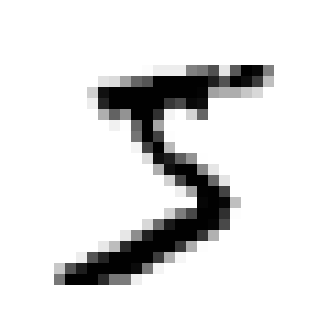

In [6]:

some_digit = X[0]
plot_digit(some_digit)

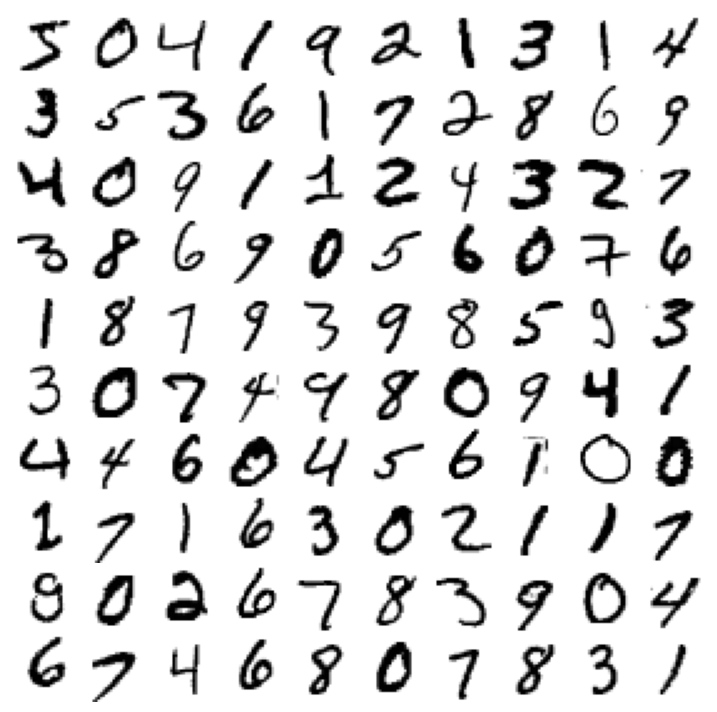

In [7]:
plot_100_digits()

## PCA

### Ejecutar PCA y ver la varianza explicada por los componentes

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)


PCA()

Text(0, 0.5, 'Variance')

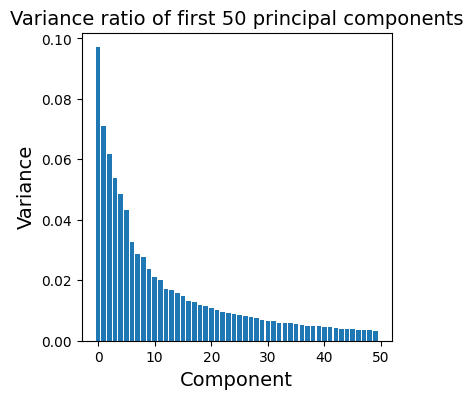

In [9]:
d = 50
plt.figure()
plt.bar(range(d), pca.explained_variance_ratio_[:d])
plt.title(f'Variance ratio of first {d} principal components')
plt.xlabel("Component")
plt.ylabel("Variance")

### Ver la varianza acumulada

In [10]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

# determinar cuantos componentes explican el 95% de la varianza
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

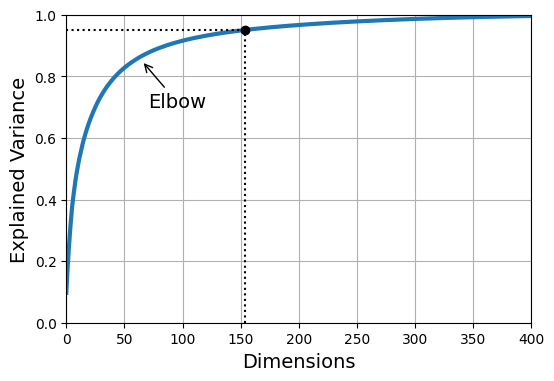

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

## Clasificar aplicando previamente PCA para reducir dimensiones
Ver resultado y tiempos de ejecución

### Primero ver como da sin PCA

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf_sgd =  make_pipeline(SGDClassifier(random_state=42))

# ESTO PUEDE LLEVAR UNOS 2 a 3 MINUTOS. REDUCIR EL SET SI LLEVA MAS DE 5 MIN . Poner X_train[:20000], y_train[:20000] por ejemplo
clf_sgd.fit(X_train, y_train)

Pipeline(steps=[('sgdclassifier', SGDClassifier(random_state=42))])

In [13]:
clf_sgd.score(X_test, y_test)

0.874

### Ahora con PCA previo buscando cantidad de componentes por RandomizedGridSearch

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    SGDClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
# acotar las muestras de entrenamiento porque tarda un rato
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('sgdclassifier',
                                              SGDClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])},
                   random_state=42)

In [15]:
rnd_search.best_params_

{'pca__n_components': 64}

Entrenar ahora con todos los datos y con los mejores parámetros

In [16]:
clf_pca_sgd = rnd_search.best_estimator_.fit(X_train, y_train)


In [18]:
clf_pca_sgd.score(X_test, y_test)

0.8852

## Visualización en 2D de los datos 

En esta parte se usa T-SNE para reducir la dimensión de los datos de 28x28=784 a 2  !!!


In [19]:
# achicar un poco los datos para ir más rápido
X_sample, y_sample = X_train[:5000], y_train[:5000]

Usamos TSNE para reducir a dimensión dos

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced = tsne.fit_transform(X_sample)

Los datos en dimensión 2 con un color para cada dígito

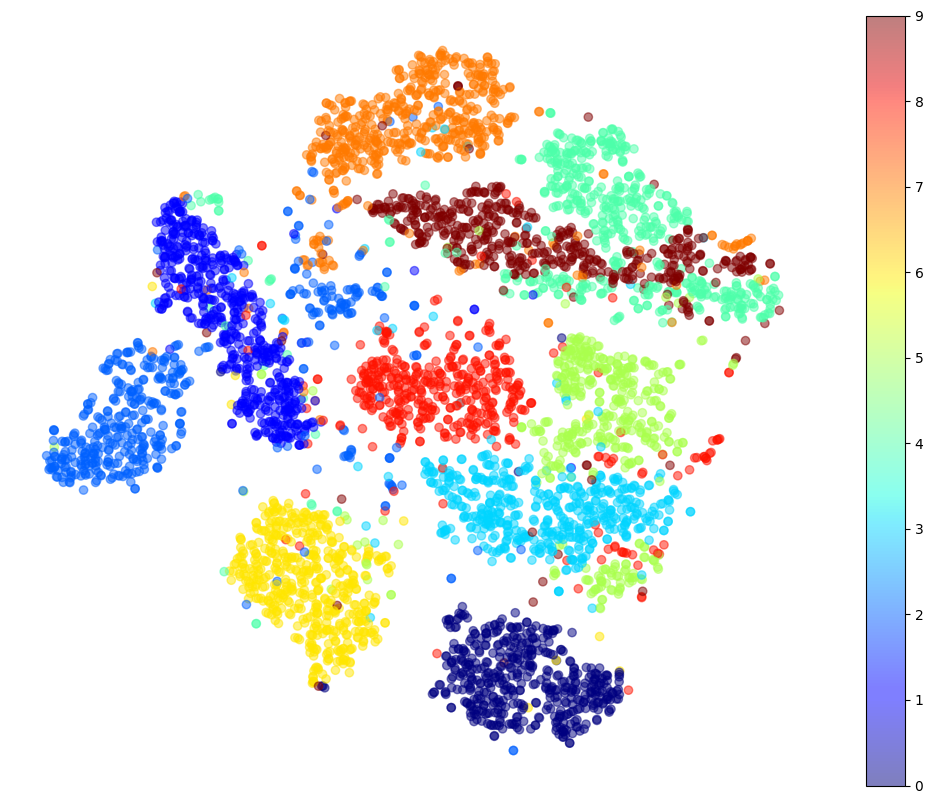

In [22]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Ver además las imágenes en el plot

In [23]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

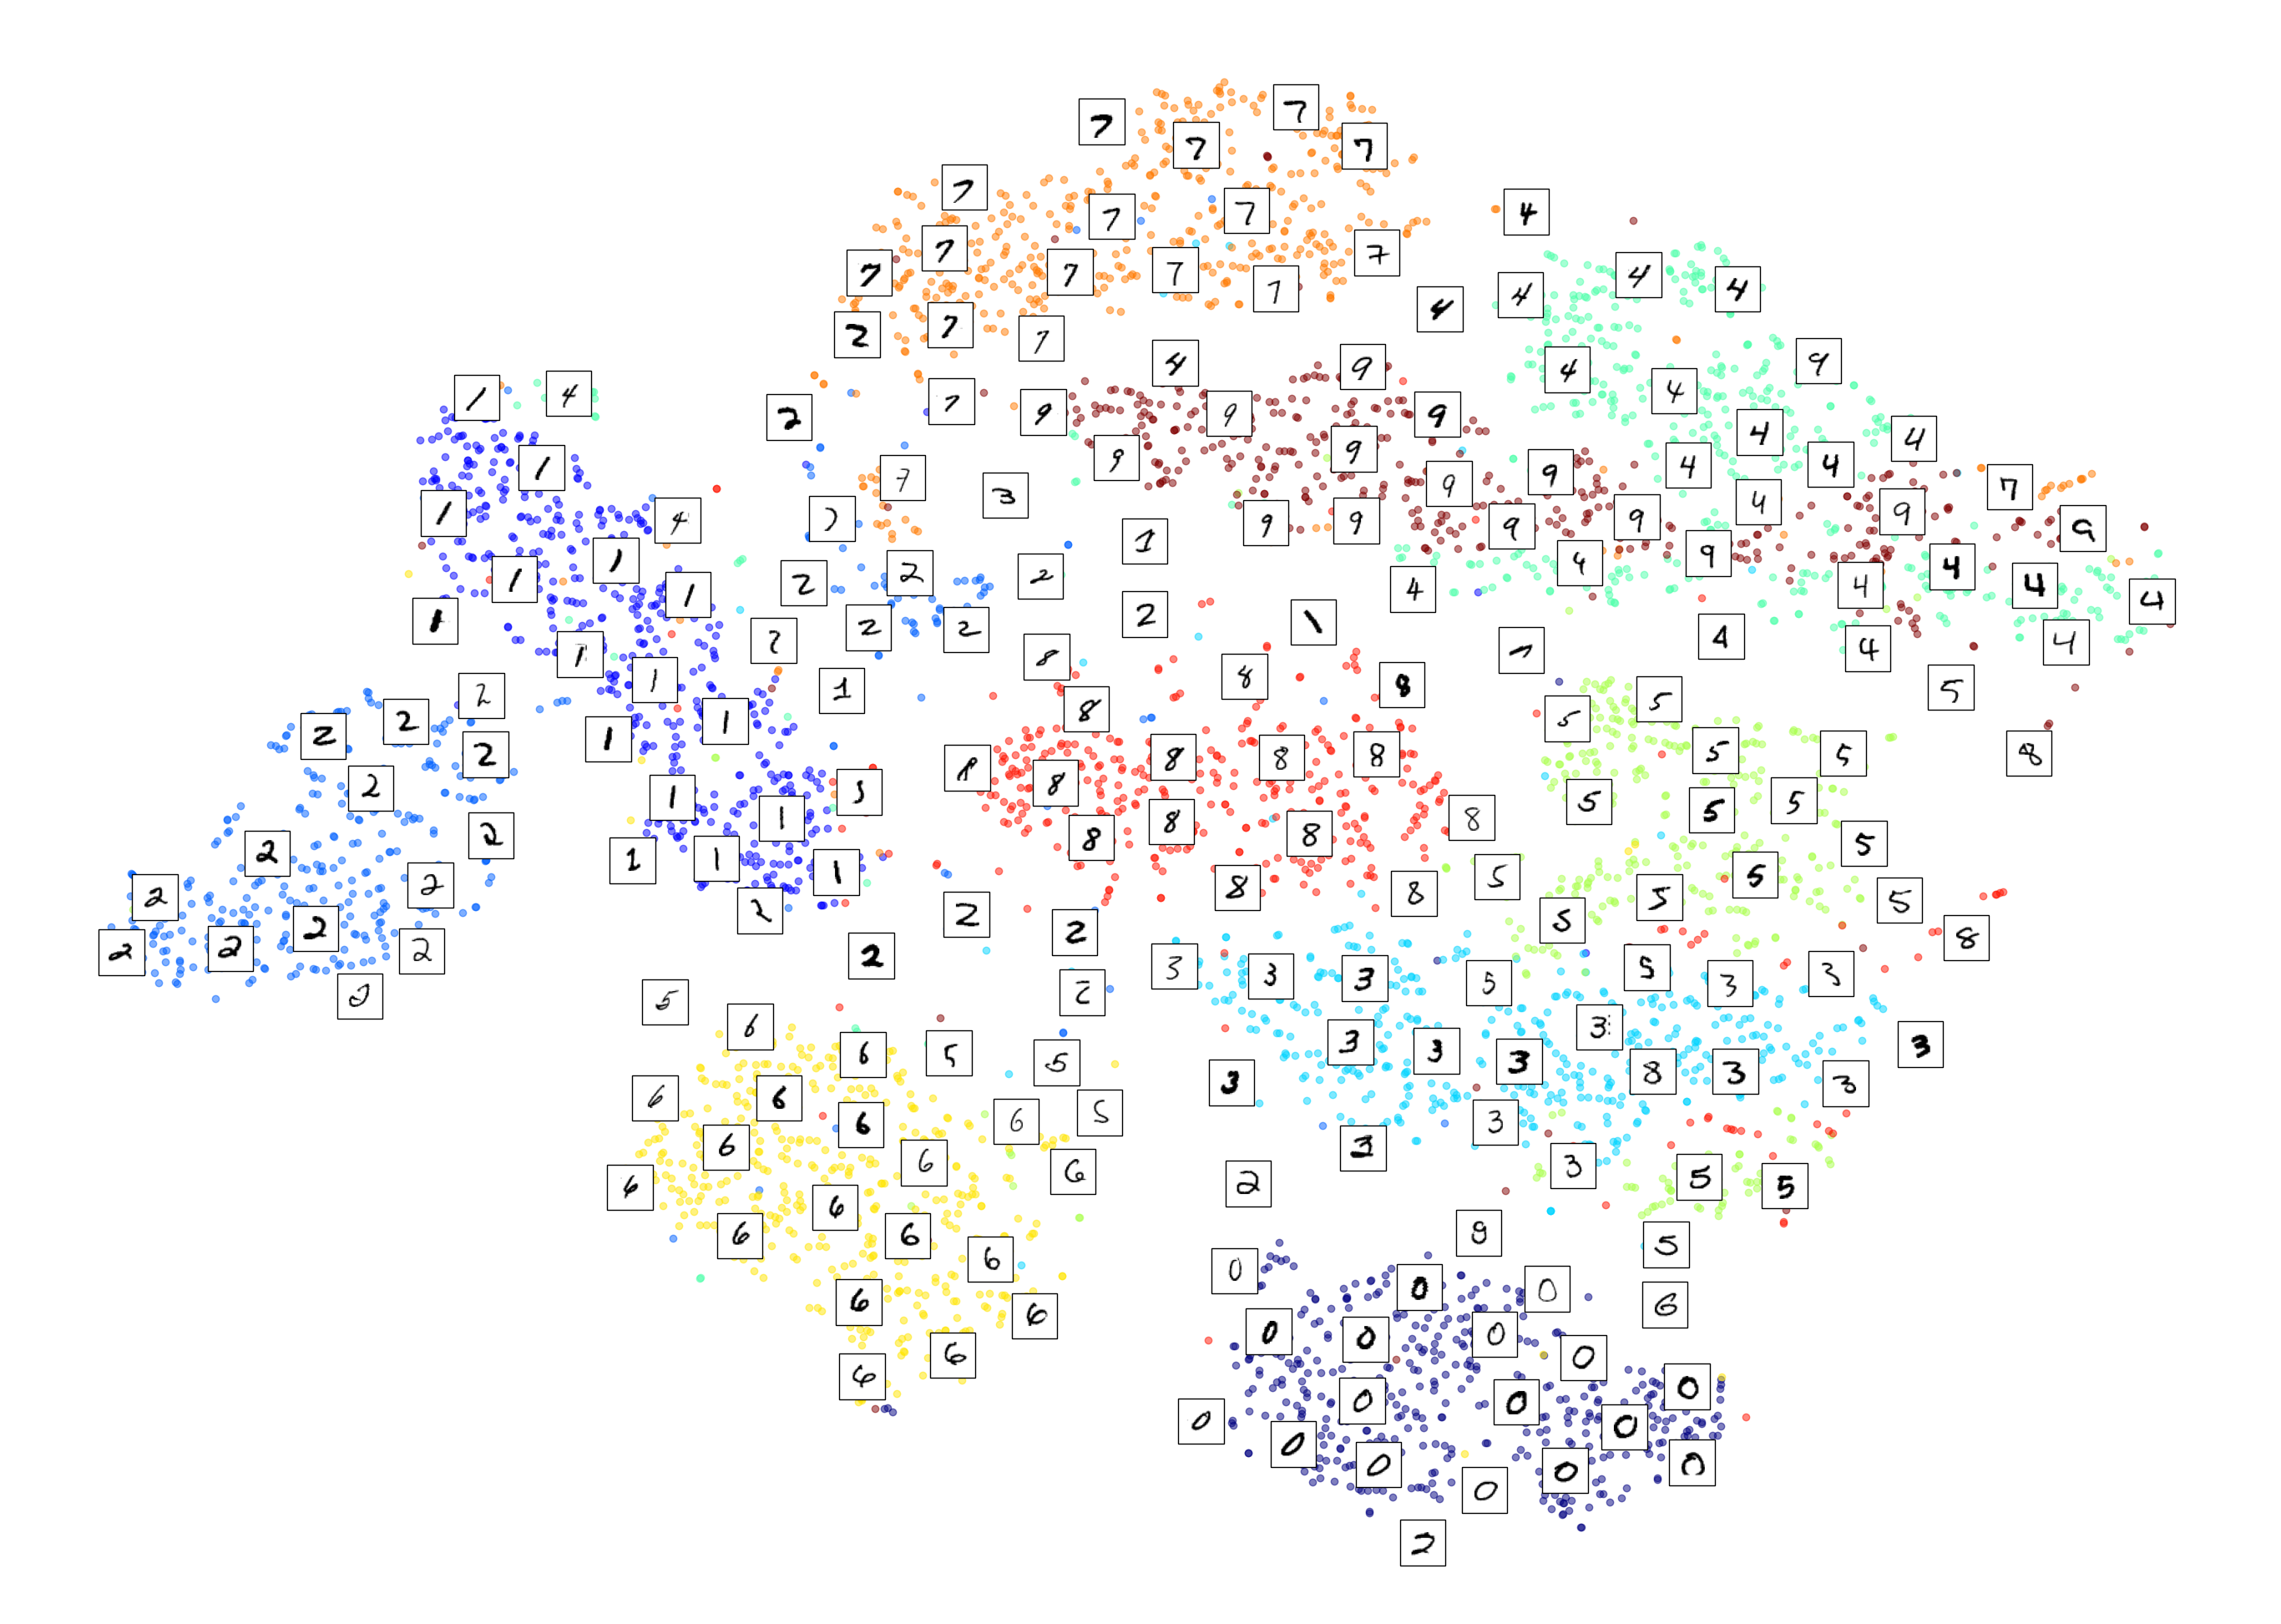

In [26]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))